# LDSSA Hackathon #1 - Binary Classification

In [1]:
# https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial

import numpy as np
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 


from sklearn.base import BaseEstimator, TransformerMixin
# https://www.youtube.com/watch?v=irHhDMbw3xo&t=10m0s
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, 
                            recall_score, f1_score, 
                            roc_auc_score, roc_curve, 
                            confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler#, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

# https://github.com/scikit-learn-contrib/category_encoders
# http://contrib.scikit-learn.org/category_encoders/
from category_encoders import OneHotEncoder, TargetEncoder

from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,auc


# Workflow


## Step 1: Get the data


In [2]:
flights = pd.read_csv('data/train.csv').set_index("ID")
date_cols = ['DATE_ARRIVAL_UTC', 'DATE_DEPARTURE_UTC', 'DATE_DEPARTURE_LCL', 'DATE_ARRIVAL_LCL']
flights[date_cols] = flights[date_cols].apply(pd.to_datetime)

In [3]:
flights.head()

,DATE_DEPARTURE_UTC,DATE_ARRIVAL_UTC,DATE_DEPARTURE_LCL,DATE_ARRIVAL_LCL,ORIGIN,ORIGIN_AIRPORT_ID,DEST,DEST_AIRPORT_ID,TAIL_NUM,OP_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DISTANCE,CANCELLED,DEP_DEL15,ARR_DEL15
ID,,,,,,,,,,,,,,,,
345355,2020-01-18 22:10:00,2020-01-18 23:59:00,2020-01-18 15:10:00,2020-01-18 15:59:00,SLC,14869,SNA,14908,N128DU,DL,19790,1056,588.0,0,0.0,0
323447,2020-01-17 21:47:00,2020-01-18 04:10:00,2020-01-17 16:47:00,2020-01-17 20:10:00,BOS,10721,SEA,14747,N486AS,AS,19930,15,2496.0,0,NaN,0
242237,2020-01-13 13:26:00,2020-01-13 14:26:00,2020-01-13 07:26:00,2020-01-13 08:26:00,DAL,11259,HOU,12191,N901WN,WN,19393,3,239.0,0,NaN,0
271408,2020-01-15 02:45:00,2020-01-15 03:37:00,2020-01-14 20:45:00,2020-01-14 21:37:00,STL,15016,DSM,11423,N778SW,WN,19393,1588,259.0,0,0.0,0
282447,2020-01-15 23:22:00,2020-01-16 00:49:00,2020-01-15 18:22:00,2020-01-15 19:49:00,CLT,11057,CHS,10994,N579NN,OH,20397,5207,168.0,0,NaN,1


In [4]:
flights.columns

Index(['DATE_DEPARTURE_UTC', 'DATE_ARRIVAL_UTC', 'DATE_DEPARTURE_LCL',
       'DATE_ARRIVAL_LCL', 'ORIGIN', 'ORIGIN_AIRPORT_ID', 'DEST',
       'DEST_AIRPORT_ID', 'TAIL_NUM', 'OP_CARRIER', 'OP_CARRIER_AIRLINE_ID',
       'OP_CARRIER_FL_NUM', 'DISTANCE', 'CANCELLED', 'DEP_DEL15', 'ARR_DEL15'],
      dtype='object')

In [5]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 419487 entries, 345355 to 224261
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   DATE_DEPARTURE_UTC     419487 non-null  datetime64[ns]
 1   DATE_ARRIVAL_UTC       419487 non-null  datetime64[ns]
 2   DATE_DEPARTURE_LCL     419487 non-null  datetime64[ns]
 3   DATE_ARRIVAL_LCL       419487 non-null  datetime64[ns]
 4   ORIGIN                 419487 non-null  object        
 5   ORIGIN_AIRPORT_ID      419487 non-null  int64         
 6   DEST                   419487 non-null  object        
 7   DEST_AIRPORT_ID        419487 non-null  int64         
 8   TAIL_NUM               419487 non-null  object        
 9   OP_CARRIER             419487 non-null  object        
 10  OP_CARRIER_AIRLINE_ID  419487 non-null  int64         
 11  OP_CARRIER_FL_NUM      419487 non-null  int64         
 12  DISTANCE               401869 non-null 

DATE_DEPARTURE_UTC            0
DATE_ARRIVAL_UTC              0
DATE_DEPARTURE_LCL            0
DATE_ARRIVAL_LCL              0
ORIGIN                        0
ORIGIN_AIRPORT_ID             0
DEST                          0
DEST_AIRPORT_ID               0
TAIL_NUM                      0
OP_CARRIER                    0
OP_CARRIER_AIRLINE_ID         0
OP_CARRIER_FL_NUM             0
DISTANCE                  17618
CANCELLED                     0
DEP_DEL15                146820
ARR_DEL15                     0
dtype: int64


<AxesSubplot:ylabel='ID'>

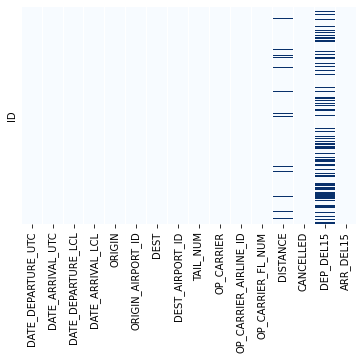

In [6]:
print(flights.isna().sum())
sns.heatmap(flights.isnull(), yticklabels = False, cbar = False, cmap="Blues")


In [7]:
print(flights[flights['DEP_DEL15'].isnull()].shape) 
flights[flights['DEP_DEL15'].isnull()]

(146820, 16)


,DATE_DEPARTURE_UTC,DATE_ARRIVAL_UTC,DATE_DEPARTURE_LCL,DATE_ARRIVAL_LCL,ORIGIN,ORIGIN_AIRPORT_ID,DEST,DEST_AIRPORT_ID,TAIL_NUM,OP_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DISTANCE,CANCELLED,DEP_DEL15,ARR_DEL15
ID,,,,,,,,,,,,,,,,
323447,2020-01-17 21:47:00,2020-01-18 04:10:00,2020-01-17 16:47:00,2020-01-17 20:10:00,BOS,10721,SEA,14747,N486AS,AS,19930,15,2496.0,0,NaN,0
242237,2020-01-13 13:26:00,2020-01-13 14:26:00,2020-01-13 07:26:00,2020-01-13 08:26:00,DAL,11259,HOU,12191,N901WN,WN,19393,3,239.0,0,NaN,0
282447,2020-01-15 23:22:00,2020-01-16 00:49:00,2020-01-15 18:22:00,2020-01-15 19:49:00,CLT,11057,CHS,10994,N579NN,OH,20397,5207,168.0,0,NaN,1
175803,2020-01-09 22:45:00,2020-01-10 00:36:00,2020-01-09 16:45:00,2020-01-09 18:36:00,DFW,11298,BNA,10693,N957NN,AA,19805,2675,631.0,0,NaN,0
363227,2020-01-20 00:08:00,2020-01-20 02:56:00,2020-01-19 16:08:00,2020-01-19 20:56:00,LAX,12892,DFW,11298,N325US,DL,19790,491,1235.0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289111,2020-01-15 17:26:00,2020-01-15 18:59:00,2020-01-15 12:26:00,2020-01-15 12:59:00,DTW,11433,CWA,11203,N820AY,9E,20363,5039,363.0,0,NaN,0
417793,2020-01-22 18:09:00,2020-01-22 19:33:00,2020-01-22 13:09:00,2020-01-22 14:33:00,MYR,13577,BWI,10821,N527NK,NK,20416,426,399.0,0,NaN,0
295955,2020-01-16 14:33:00,2020-01-16 16:11:00,2020-01-16 09:33:00,2020-01-16 11:11:00,EWR,11618,BOS,10721,N292JB,B6,20409,2380,NaN,0,NaN,0


In [8]:
print(flights.TAIL_NUM.values)
print(flights.OP_CARRIER.nunique())

['N128DU' 'N486AS' 'N901WN' ... 'N832UA' 'N286WN' 'N907FJ']
17


array([[<AxesSubplot:title={'center':'ARR_DEL15'}>,
        <AxesSubplot:title={'center':'CANCELLED'}>,
        <AxesSubplot:title={'center':'DEP_DEL15'}>],
       [<AxesSubplot:title={'center':'DEST_AIRPORT_ID'}>,
        <AxesSubplot:title={'center':'DISTANCE'}>,
        <AxesSubplot:title={'center':'OP_CARRIER_AIRLINE_ID'}>],
       [<AxesSubplot:title={'center':'OP_CARRIER_FL_NUM'}>,
        <AxesSubplot:title={'center':'ORIGIN_AIRPORT_ID'}>,
        <AxesSubplot:>]], dtype=object)

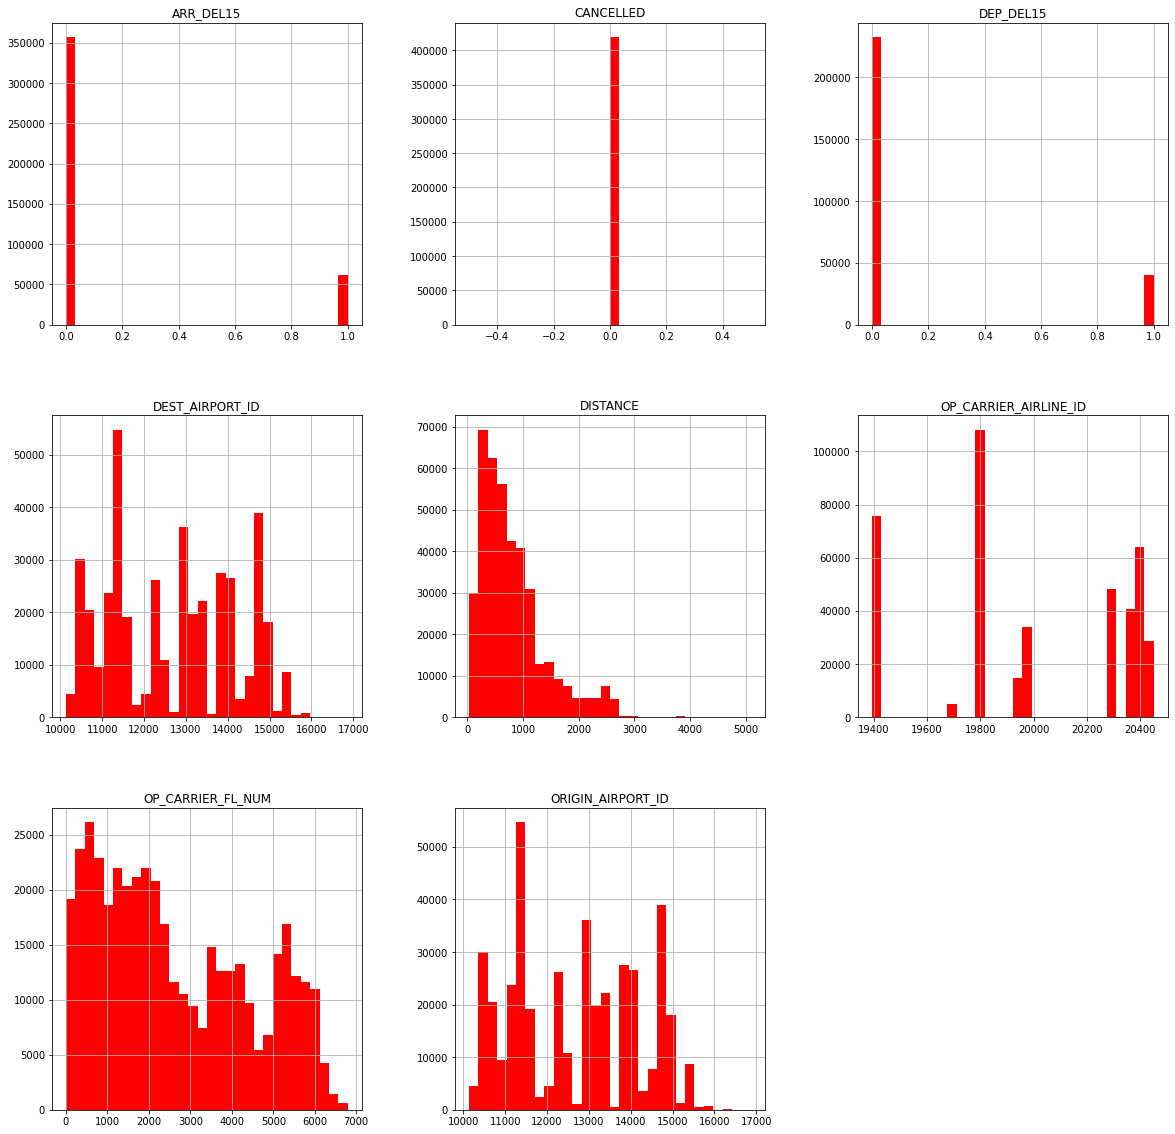

In [9]:
flights.hist(bins = 30, figsize = (20,20), color = 'r')


In [10]:
# only keep flights that haven't been cancelled and remove cancelled flights
flights = flights[flights['CANCELLED'] == 0]

In [11]:
flights.drop(['CANCELLED'], axis=1, inplace=True)

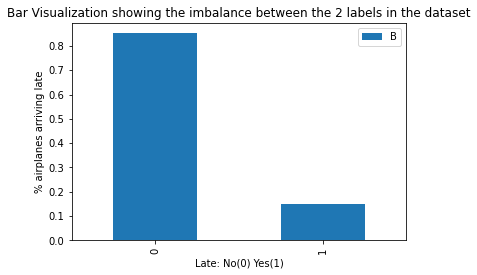

In [12]:
# chek if the database is imbalanced
flights['ARR_DEL15'].value_counts(normalize=True).plot(kind='bar')
plt.title('Bar Visualization showing the imbalance between the 2 labels in the dataset')
plt.xlabel('Late: No(0) Yes(1)')
plt.ylabel('% airplanes arriving late')
plt.legend('Bar Visualization showing the imbalance between the 2 labels in the dataset')

In [13]:
def get_total_seconds(row):
    return (row['DATE_ARRIVAL_UTC'] - row['DATE_DEPARTURE_UTC']).total_seconds()

flights['DURATION'] = flights.apply(
    lambda row: get_total_seconds(row), axis=1
)

In [14]:
columns_to_filter = [
    'OP_CARRIER',
    'ORIGIN', 'DEST',
    'DISTANCE', 'DURATION',
    'ARR_DEL15', 'DEP_DEL15'
]

x = flights.filter(items=columns_to_filter).sort_values(['ORIGIN', 'DEST', 'DURATION']).drop_duplicates()

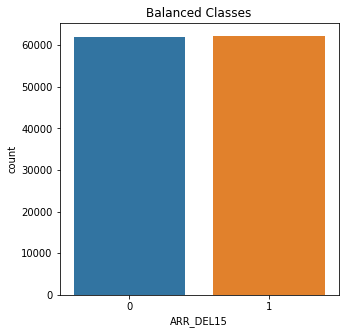

(419487, 16)

In [15]:
# Shuffle the Dataset.
shuffled_df = flights.sample(frac=1, random_state=42)

# Put all the flights class in a separate dataset.
fraud_df = flights.loc[flights['ARR_DEL15'] == 1]

#Randomly select 62000 observations from the flights (majority class)
non_fraud_df = flights.loc[flights['ARR_DEL15'] == 0].sample(n=62000, random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([fraud_df, non_fraud_df])

#plot the dataset after the undersampling
plt.figure(figsize=(5, 5))
sns.countplot('ARR_DEL15', data=normalized_df)
plt.title('Balanced Classes')
plt.show()
flights.shape

In [16]:
unscaled_inputs_all = flights.iloc[:, np.r_[1:-1]]
unscaled_inputs_all

""
ID
345355
323447
242237
271408
282447
...
374775
295665
365119


In [17]:
from pandas_profiling import ProfileReport
report = ProfileReport(flights)
#report

In [18]:
date_cols = ['DATE_ARRIVAL_UTC', 'DATE_DEPARTURE_UTC', 'DATE_DEPARTURE_LCL', 'DATE_ARRIVAL_LCL']
flights[date_cols] = flights[date_cols].apply(pd.to_datetime)

In [19]:
#flights['WEEK_DAY'] = flights['DATE_ARRIVAL_UTC'].dt.weekday
#flights.groupby(['WEEK_DAY']).agg({'ARR_DEL15': ['count','sum']})

array([18, 13, 15, 16, 10, 20, 14,  3,  1, 11, 17,  2,  4, 12, 22,  6, 23,
        8,  7,  5, 19,  9, 21, 31])

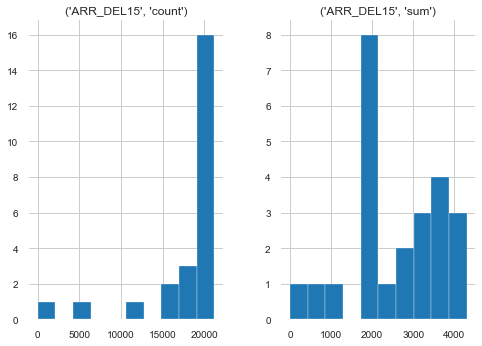

In [20]:
flights['MONTH_DAY'] = flights['DATE_ARRIVAL_UTC'].dt.day

flights.groupby(['MONTH_DAY']).agg({'ARR_DEL15': ['count','sum']}).hist()
flights['MONTH_DAY'].unique()

,ARR_DEL15
,sum
MONTH,
1,62195


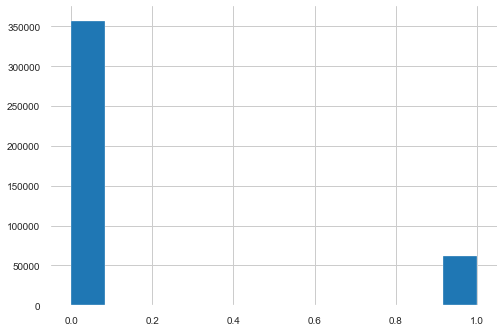

In [21]:
flights['MONTH'] = flights['DATE_DEPARTURE_LCL'].dt.month.copy()
flights.groupby(['MONTH'])['ARR_DEL15'].hist(bins=12)
flights.groupby(['MONTH']).agg({'ARR_DEL15': ['sum']})

In [22]:
#flights['HOUR_OF_DAY'] = flights['DATE_ARRIVAL_UTC'].dt#.hour
#f = flights.groupby(['MONTH_DAY']).agg({'ARR_DEL15': ['count','sum']})

In [23]:
flights = pd.read_csv('data/train.csv')
flights_without_distance = flights[flights.DISTANCE.isnull()]
print(flights_without_distance.shape)
flights_without_distance.head()

(17618, 17)


,ID,DATE_DEPARTURE_UTC,DATE_ARRIVAL_UTC,DATE_DEPARTURE_LCL,DATE_ARRIVAL_LCL,ORIGIN,ORIGIN_AIRPORT_ID,DEST,DEST_AIRPORT_ID,TAIL_NUM,OP_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DISTANCE,CANCELLED,DEP_DEL15,ARR_DEL15
11,22614,2020-01-02 23:10:00,2020-01-03 02:36:00,2020-01-02 16:10:00,2020-01-02 21:36:00,TUS,15376,ATL,10397,N382DN,DL,19790,2393,NaN,0,0.0,0
29,404179,2020-01-21 23:18:00,2020-01-22 00:10:00,2020-01-21 17:18:00,2020-01-21 18:10:00,FAR,11637,MSP,13487,N935SW,OO,20304,3680,NaN,0,0.0,0
34,292196,2020-01-15 16:05:00,2020-01-15 17:59:00,2020-01-15 10:05:00,2020-01-15 12:59:00,DFW,11298,ATL,10397,N371DN,DL,19790,1243,NaN,0,NaN,0
44,55140,2020-01-03 14:51:00,2020-01-03 18:39:00,2020-01-03 08:51:00,2020-01-03 10:39:00,MSP,13487,SFO,14771,N916DU,DL,19790,1162,NaN,0,0.0,0
86,162241,2020-01-10 06:36:00,2020-01-10 07:18:00,2020-01-09 22:36:00,2020-01-09 23:18:00,SFO,14771,MRY,13476,N166SY,OO,20304,5850,NaN,0,0.0,0


In [24]:
OP_CARRIER_flights = flights.groupby('OP_CARRIER').sum()
OP_CARRIER_flights.head(18)

,ID,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DISTANCE,CANCELLED,DEP_DEL15,ARR_DEL15
OP_CARRIER,,,,,,,,,
9E,3471030142,192429422,192349632,322611009,80865232,6686611.0,0,1313.0,1978
AA,11111010040,669569420,669508734,1048357870,80778252,50574152.0,0,5193.0,8228
AS,3021614657,198924334,198972555,292153870,11528430,18507776.0,0,1820.0,3249
B6,3693824031,216670682,216640808,355096191,18587172,18666342.0,0,1934.0,2929
DL,12133127124,683808632,683635373,1093931830,96805394,48462839.0,0,4173.0,6644
EV,1514685737,91366382,91340305,147897892,30565092,3419548.0,0,661.0,1243
F9,1815649160,112268105,112265684,177568404,11699206,8458351.0,0,982.0,1411
G4,1026938322,69834605,69845064,109478000,7179942,4578205.0,0,686.0,1204
HA,1041665857,63347223,63352769,97012630,1141581,3779694.0,0,302.0,536


<AxesSubplot:xlabel='ID'>

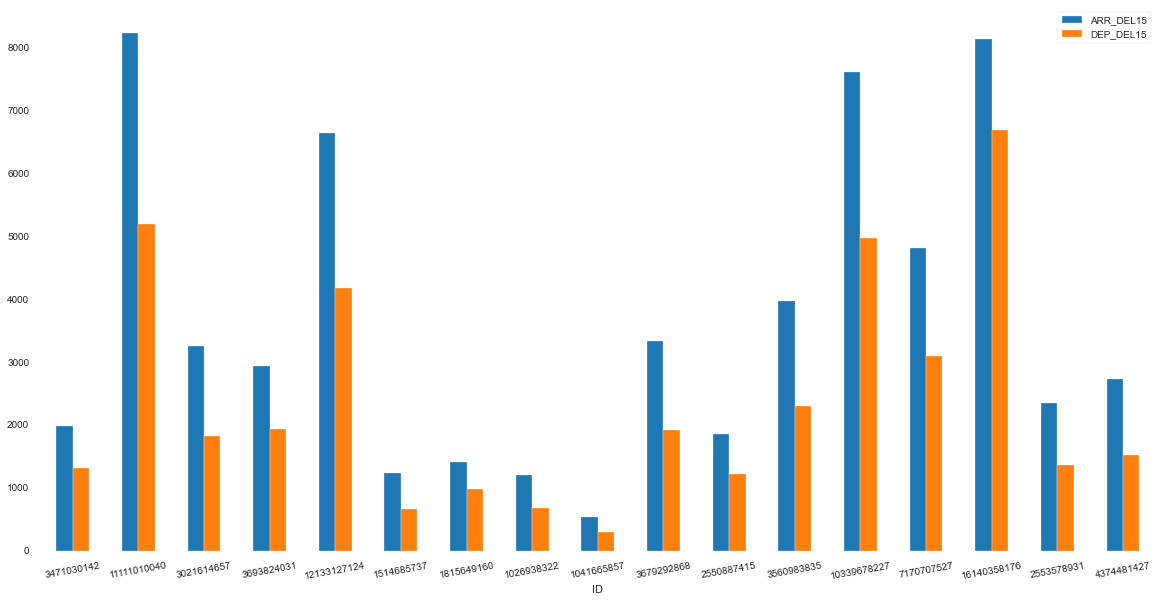

In [25]:
OP_CARRIER_flights.plot.bar(x='ID', y=['ARR_DEL15', 'DEP_DEL15'], rot=10, figsize=(20,10))

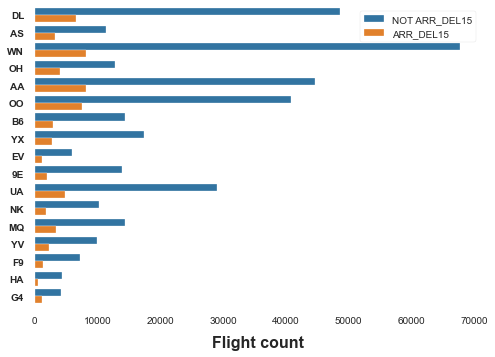

In [26]:
# Plot graph with delay and not delay comparation
#flights['DELAY_LEVEL'] = 
ax = sns.countplot(y="OP_CARRIER", hue='ARR_DEL15', data=flights)

plt.setp(ax.get_xticklabels(), fontsize=10, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=10, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)

# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('NOT ARR_DEL15')
L.get_texts()[1].set_text('ARR_DEL15')
plt.show()

In [27]:
#flights['ARRIVAL_HOUR_DAY'] = flights['DATE_ARRIVAL_UTC'].dt.hour
#HOUR_DAY_flights = flights.groupby('ARRIVAL_HOUR_DAY').sum()
#HOUR_DAY_flights.head()
#HOUR_DAY_flights.plot.bar(x='ID', y='ARR_DEL15', rot=10, figsize=(20,10))

In [28]:
#flights['DEPARTURE_HOUR_DAY'] = flights['DATE_DEPARTURE_UTC'].dt.hour
#HOUR_DAY_flights = flights.groupby('DEPARTURE_HOUR_DAY').sum()
#HOUR_DAY_flights.head()
#HOUR_DAY_flights.plot.bar(x='ID', y='ARR_DEL15', rot=10, figsize=(20,10))

In [29]:
#X['WEEK_DAY'] = X['DATE_ARRIVAL_UTC'].dt.weekday

## Step 2: Data analysis and preparation

This step has some more definitive substeps than the previous. In general you'll hit the following steps:

1. Data analysis
1. Dealing with data problems
1. Feature engineering
1. Feature selection

### 2.1 Data analysis
EDA (Exploratory Dataset Analysis)

You've already learned quite a bit about how to do Data Analysis. you have a nice pile of tools that you can use to get a feel for the type of data that you are dealing with. Use them until you feel comfortable enough that you could confidently describe the most important characteristics of the data set you are working with.

### Numerical values
### Categorical values
### Empty values

*DEP_DEL15*: some values are empty. We will convertit in 3 columns, one for the ones that don't have values

### redundant values
### related values
### imbalanced data?
### duplicated values inside row?

In [30]:
flights.describe()

,ID,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DISTANCE,CANCELLED,DEP_DEL15,ARR_DEL15
count,419487.000000,419487.000000,419487.000000,419487.000000,419487.000000,401869.000000,419487.0,272667.000000,419487.000000
mean,212639.517973,12656.739730,12655.545597,19993.369749,2628.837404,803.586898,0.0,0.147227,0.148264
std,123449.043509,1525.037067,1524.512434,375.543815,1825.643818,589.887296,0.0,0.354333,0.355362
min,0.000000,10135.000000,10135.000000,19393.000000,1.000000,31.000000,0.0,0.000000,0.000000
25%,105540.500000,11292.000000,11292.000000,19790.000000,1073.000000,370.000000,0.0,0.000000,0.000000
50%,212787.000000,12889.000000,12889.000000,19977.000000,2184.000000,645.000000,0.0,0.000000,0.000000
75%,319018.500000,14027.000000,14027.000000,20378.000000,4115.000000,1045.000000,0.0,0.000000,0.000000
max,435681.000000,16869.000000,16869.000000,20452.000000,6799.000000,5095.000000,0.0,1.000000,1.000000


In [31]:
print('Searching for redaundante columns!')
print(f'DEST: {flights.DEST.nunique()}')
print(f'DEST_AIRPORT_ID: {flights.DEST_AIRPORT_ID.nunique()}')

print(f'ORIGIN: {flights.ORIGIN.nunique()}')
print(f'ORIGIN_AIRPORT_ID: {flights.ORIGIN_AIRPORT_ID.nunique()}')

# So we don't need to have both columns, becouse we can use one or other to get all rows

Searching for redaundante columns!
DEST: 350
DEST_AIRPORT_ID: 350
ORIGIN: 351
ORIGIN_AIRPORT_ID: 351


In [32]:
flights.dtypes

ID                         int64
DATE_DEPARTURE_UTC        object
DATE_ARRIVAL_UTC          object
DATE_DEPARTURE_LCL        object
DATE_ARRIVAL_LCL          object
ORIGIN                    object
ORIGIN_AIRPORT_ID          int64
DEST                      object
DEST_AIRPORT_ID            int64
TAIL_NUM                  object
OP_CARRIER                object
OP_CARRIER_AIRLINE_ID      int64
OP_CARRIER_FL_NUM          int64
DISTANCE                 float64
CANCELLED                  int64
DEP_DEL15                float64
ARR_DEL15                  int64
dtype: object

check  the number of unique values


In [33]:
flights.nunique()

ID                       419487
DATE_DEPARTURE_UTC        29661
DATE_ARRIVAL_UTC          30137
DATE_DEPARTURE_LCL        26687
DATE_ARRIVAL_LCL          28477
ORIGIN                      351
ORIGIN_AIRPORT_ID           351
DEST                        350
DEST_AIRPORT_ID             350
TAIL_NUM                   5376
OP_CARRIER                   17
OP_CARRIER_AIRLINE_ID        17
OP_CARRIER_FL_NUM          6715
DISTANCE                   1468
CANCELLED                     1
DEP_DEL15                     2
ARR_DEL15                     2
dtype: int64

In [34]:
ARR_DEL15_flights = flights[flights['ARR_DEL15'] == 1]
ARR_DEL15_flights.shape
percentage_ARR_DEL15 = ARR_DEL15_flights.shape[0] / flights.shape[0] * 100
print(f'% of delayed arrivals: {percentage_ARR_DEL15:.2f}%')
percentage_ARR_DEL15 = (flights.shape[0] - ARR_DEL15_flights.shape[0]) / flights.shape[0] * 100
print(f'% of not delayed arrivals: {percentage_ARR_DEL15:.2f}%')

% of delayed arrivals: 14.83%
% of not delayed arrivals: 85.17%





### 2.2 Dealing with data problems

Your data analysis will certainly uncover data problems. Some of these data problems you may be able to deal with once and others you may need to make part of a pipeline. An example of a data problem that you would deal with once at the beginning of your workflow is changing numbers that are stored as strings in a csv into actual numbers. An example of something that you might want to put off until later is filling in nans so that you could experiment with imputation strategies.


## Filling empty cells or Nan

- DISTANCE
- DATE_ARRIVAL_UTC

In [35]:
# Dealing with datetimes where the type is object
flights['DATE_ARRIVAL_UTC'] = pd.to_datetime(flights['DATE_ARRIVAL_UTC'])
flights['DATE_DEPARTURE_UTC'] = pd.to_datetime(flights['DATE_DEPARTURE_UTC'])
flights['DATE_ARRIVAL_LCL'] = pd.to_datetime(flights['DATE_ARRIVAL_LCL'])
flights['DATE_DEPARTURE_LCL'] = pd.to_datetime(flights['DATE_DEPARTURE_LCL'])

flights.dtypes

ID                                int64
DATE_DEPARTURE_UTC       datetime64[ns]
DATE_ARRIVAL_UTC         datetime64[ns]
DATE_DEPARTURE_LCL       datetime64[ns]
DATE_ARRIVAL_LCL         datetime64[ns]
ORIGIN                           object
ORIGIN_AIRPORT_ID                 int64
DEST                             object
DEST_AIRPORT_ID                   int64
TAIL_NUM                         object
OP_CARRIER                       object
OP_CARRIER_AIRLINE_ID             int64
OP_CARRIER_FL_NUM                 int64
DISTANCE                        float64
CANCELLED                         int64
DEP_DEL15                       float64
ARR_DEL15                         int64
dtype: object

In [36]:
# getting the correlation matrix  
cor_mat = flights.corr()

# Bit of crazy numpy. We are getting the triangular matrix 
# the same size as our correlation matrix, with just Trues and 
# Falses, to then use in a mask. (you can just copy paste this though) 
lower_triangle_mask = np.triu(np.ones(cor_mat.shape)).astype(np.bool)

# Now mask the correlation matrix, keeping only the lower triangle 
cor_mat_lower = cor_mat.mask(lower_triangle_mask)

# Et voila! 
display(cor_mat_lower)

,ID,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DISTANCE,CANCELLED,DEP_DEL15,ARR_DEL15
ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORIGIN_AIRPORT_ID,-0.007647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEST_AIRPORT_ID,-0.009194,0.016026,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OP_CARRIER_AIRLINE_ID,-0.005145,-0.047095,-0.047160,NaN,NaN,NaN,NaN,NaN,NaN
OP_CARRIER_FL_NUM,-0.022777,-0.052145,-0.058139,0.407724,NaN,NaN,NaN,NaN,NaN
DISTANCE,-0.025257,0.087126,0.088473,-0.126369,-0.353141,NaN,NaN,NaN,NaN
CANCELLED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEP_DEL15,-0.024745,-0.000491,0.002717,0.031229,0.023681,0.021550,NaN,NaN,NaN
ARR_DEL15,-0.020430,-0.001703,0.006340,0.062606,0.030381,0.019083,NaN,0.713799,NaN


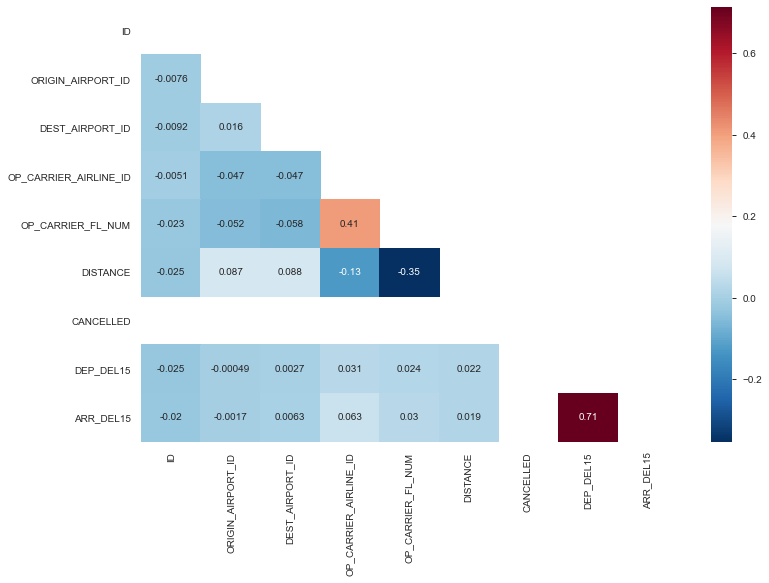

In [37]:
plt.figure(figsize = (12,8))

sns.heatmap(cor_mat_lower, 
            annot=True,
            cmap='RdBu_r'); 

In [38]:
#flights.drop(['ARR_DEL15', 'DATE_DEPARTURE_LCL', 'DATE_ARRIVAL_LCL', 'TAIL_NUM'], axis=1).head()

flights.TAIL_NUM.nunique()

5376

In [39]:
flights.head()

,ID,DATE_DEPARTURE_UTC,DATE_ARRIVAL_UTC,DATE_DEPARTURE_LCL,DATE_ARRIVAL_LCL,ORIGIN,ORIGIN_AIRPORT_ID,DEST,DEST_AIRPORT_ID,TAIL_NUM,OP_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DISTANCE,CANCELLED,DEP_DEL15,ARR_DEL15
0,345355,2020-01-18 22:10:00,2020-01-18 23:59:00,2020-01-18 15:10:00,2020-01-18 15:59:00,SLC,14869,SNA,14908,N128DU,DL,19790,1056,588.0,0,0.0,0
1,323447,2020-01-17 21:47:00,2020-01-18 04:10:00,2020-01-17 16:47:00,2020-01-17 20:10:00,BOS,10721,SEA,14747,N486AS,AS,19930,15,2496.0,0,NaN,0
2,242237,2020-01-13 13:26:00,2020-01-13 14:26:00,2020-01-13 07:26:00,2020-01-13 08:26:00,DAL,11259,HOU,12191,N901WN,WN,19393,3,239.0,0,NaN,0
3,271408,2020-01-15 02:45:00,2020-01-15 03:37:00,2020-01-14 20:45:00,2020-01-14 21:37:00,STL,15016,DSM,11423,N778SW,WN,19393,1588,259.0,0,0.0,0
4,282447,2020-01-15 23:22:00,2020-01-16 00:49:00,2020-01-15 18:22:00,2020-01-15 19:49:00,CLT,11057,CHS,10994,N579NN,OH,20397,5207,168.0,0,NaN,1



### 2.3 Feature engineering

Once you've got some clean data and have a benchmark model as a reference you may want to create some new features out of the existing features. 

Create the following columns:
- *Velocity*: the average of the airplanes
- *Days (0 to 6) of the plane*:  with 0 or 1
- *Months (0 to 12) of the plane*:  with 0 or 1
- *Hour of departure*




### 2.4 Feature selection

You can do feature selection in a few different stages. One stage is right at the beginning when you can remove features that you KNOW for sure should not be in there. Examples of these are features that are all unique, all one value, are leakage, or are disallowed by law. Examples of features that you may want to remove at a later stage are because you found out that they are redundant or don't have any predictive power.


### Hyperparameters
Future work

## Step 3: Train model

You know the drill here. Based upon the attributes of the problem at hand (binary classification, multi-class classification, supervised, unsupervised, regression, etc.), choose a few different types of models to experiment with. Note that you should start as simple as possible in order to keep your complexity under control.

I'll also take the opportunity to, one more time, stress the importance of creating a training and test set. Never mix the two. Ever.


- *Logist Regression*
- *KNN - Decison tree*: with sets of features
- *Radom Forest*: with sets of features, for example, max_deph 3, 5, 8

### Normalize

Use one method to normalize data:
- RobustScaler

### Model selection


### Establish a simple baseline FAST


### Incrementally increase complexity



In [40]:
class ColPrinter(BaseEstimator, TransformerMixin):

    def __init__(self, iter):
        self.iter = iter

    def fit(self, *args, **kwargs):
        return self

    def transform(self, X, *_):
        print('-'*80)
        print(self.iter)
        #if self.iter == 'Starting Modeling...':
        #    print(X)
        
        #print(X.columns)
        #print(X.isna().sum())
        #print(df.WEEK_DAY.unique())
        #print(df.head(5))
        return X

In [41]:
class DateTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, colname):
        self.colname = colname
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        #x_timestamp = x_copy[self.colname].apply(pd.to_datetime)
        df.loc[:, self.colname+'_year'] = df[self.colname].apply(pd.to_datetime).apply(lambda t: t.year)
        #col_year = "%month"%self.colname        
        df.loc[:, self.colname+'_month'] = df[self.colname].apply(pd.to_datetime).apply(lambda t: t.month)
        df.loc[:, self.colname+'_hour']= x_copy[self.colname].apply(pd.to_datetime).apply(lambda t: t.hour)
        
        return x_copy

In [42]:
class AddDurationColumn(BaseEstimator, TransformerMixin):
    def fit(self, X, y, **fit_params):
        return self

    def transform(self, X, *_):
        df = X.copy()
        df['DURATION'] = df.apply(
            lambda row: (row['DATE_ARRIVAL_UTC'] - row['DATE_DEPARTURE_UTC']).total_seconds(),
            axis=1)
        return df 

In [43]:
class DistanceFixNA(BaseEstimator, TransformerMixin):
    INTERVAL_GAP = 15
    
    def __init__(self):
        self.data_duration = {}

    def _get_hours_and_interval(self, duration):
        minutes = duration / 60
        hours = int(minutes / 60)
        minutes -= hours * 60
        interval = math.ceil(minutes / DistanceFixNA.INTERVAL_GAP)

        return str(hours), interval

    def add_duration(self, duration, distance):
        hours, interval = self._get_hours_and_interval(duration)        

        if hours not in self.data_duration:
            self.data_duration[hours] = {}
        
        if interval not in self.data_duration[hours]:
            self.data_duration[hours][interval] = {
                'distance': distance, 'count': 1}
            return
        
        d = self.data_duration[hours][interval]
        count = d['count'] + 1
        d['distance'] = (d['distance'] * d['count'] + distance) /  count
        d['count'] = count

    def calculate_duration(self, duration):
        hours, interval = self._get_hours_and_interval(duration)
        if hours not in self.data_duration:
            hours_no = int(hours)
            for h in range(hours_no, 0, -1):
                if str(h) in self.data_duration and str(hours_no - h) in self.data_duration:
                    break

            dh1 = self.data_duration[str(h)]
            if interval in dh1:
                d1 = dh1[interval]['distance']
            else:
                d1 = next(iter(dh1.values()))['distance']

            dh2 = self.data_duration[str(hours_no - h)]
            if interval in dh2:
                d2 = dh2[interval]['distance']
            else:
                d2 = next(iter(dh2.values()))['distance']
            self.add_duration(duration, d1 + d2)

        dh = self.data_duration[hours]
        if interval in dh:
            return dh[interval]['distance'] 
        return next(iter(dh.values()))['distance']

    def fit(self, X, y, **fit_params):
        data = X[['ORIGIN', 'DEST', 'DISTANCE']].dropna().copy()
        data.set_index(['ORIGIN', 'DEST'])['DISTANCE']
        self.distance_mapping = data.to_dict()     
        self.data_distance = {}
        for i, row in X.iterrows():
            if not np.isnan(row['DISTANCE']):
                self.data_distance[(row['ORIGIN'], row['DEST'])] = row['DISTANCE']
                self.add_duration(row['DURATION'], row['DISTANCE'])
        return self
    
    def get_distance(self, row):
        if (row['ORIGIN'], row['DEST']) in self.data_distance:
            return self.data_distance[(row['ORIGIN'], row['DEST'])]
        distance = self.calculate_duration(row['DURATION'])
        return distance

    def transform(self, X, *_):
        '''
        Pop the empty distances cells with values of other rows where the 
        origin and destiny are the same and if we don't have pop the empty 
        row without distances with the median. WHY median? don't get so
        affected with outliers        
        '''
        df = X.copy()
        df['DISTANCE'] = df.apply(
            lambda row: self.get_distance(row)
                if np.isnan(row['DISTANCE'])
                else row['DISTANCE'],
            axis=1)
        return df 

In [44]:
class RemoveObjectColumns(TransformerMixin):
    
    def transform(self, X, *_):
        return X.select_dtypes(exclude='object').copy()
    
    def fit(self, *_):
        return self    

class DroppingColumns(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns_to_drop=[]):
        self.columns_to_drop = columns_to_drop

    def transform(self, X, *_):
        df = X.drop(self.columns_to_drop, axis=1).copy()
        return df
    
    def fit(self, *_):
        return self  

    
class AddWeekDayColumn(BaseEstimator, TransformerMixin):
    
    def transform(self, X_trans, *_):
        X = X_trans.copy()
        X['ARRIVAL_WEEK_DAY'] = X['DATE_ARRIVAL_UTC'].dt.dayofweek
        X['DEPARTURE_WEEK_DAY'] = X['DATE_DEPARTURE_UTC'].dt.dayofweek

        return X
    
    def fit(self, *_):
        return self
    
    
class AddDayColumn(BaseEstimator, TransformerMixin):
    
    def transform(self, X_trans, *_):
        X = X_trans.copy()
        X['ARRIVAL_DAY'] = X['DATE_ARRIVAL_UTC'].dt.day
        X['DEPARTURE_DAY'] = X['DATE_DEPARTURE_UTC'].dt.day

        return X
    
    def fit(self, *_):
        return self


class AddHourDayColumn(BaseEstimator, TransformerMixin):
    
    def transform(self, X_trans, *_):
        X = X_trans.copy()
        X['ARRIVAL_HOUR_DAY'] = X['DATE_ARRIVAL_UTC'].dt.hour
        X['DEPARTURE_HOUR_DAY'] = X['DATE_DEPARTURE_UTC'].dt.hour
        return X
    
    def fit(self, *_):
        return self


class JoinOrinAndDest(BaseEstimator, TransformerMixin):
        
    def transform(self, X_trans, *_):
        X = X_trans.copy()
        X['ORIGIN_DEST'] = X['ORIGIN'] + '_' + X['DEST']
        return X
    
    def fit(self, *_):
        return self

In [45]:
class AddSpeedColumn(BaseEstimator, TransformerMixin):
        
    def transform(self, X_trans, *_):
        X = X_trans.copy()
        X['SPEED'] = X['DISTANCE'] / X['DURATION']
        return X
    
    def fit(self, *_):
        return self

In [46]:
class fillDEP_DEL15nas(BaseEstimator, TransformerMixin):

    def fit(self, X=None, y=None, **fit_params):
        return self

    def transform(self, data):
        X = data.copy()
        X['DEP_DEL15'] = X['DEP_DEL15'].fillna(X['DEP_DEL15'].mean())
        return X
    

class CreateTimeFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, cols=[]):
        self.cols = cols

    def fit(self, X=None, y=None, **fit_params):
        return self

    def transform(self, data):
        X = data.copy()
        for col in self.cols:
            X["HOUR" + col.replace("DATE","")] = X[col].dt.hour
            X["WEEK_DAY" + col.replace("DATE","")] = X[col].dt.dayofweek
        return X

time_features_cols = ['DATE_DEPARTURE_LCL','DATE_ARRIVAL_LCL']
# This is just a list with the name of the new time features we created in the step "create_time_features"
new_time_variables = [ft+col.replace("DATE","") for col in time_features_cols for ft in ["WEEK_DAY", "HOUR"]]
cols_to_drop = ['OP_CARRIER_FL_NUM', 'TAIL_NUM', 'DATE_DEPARTURE_UTC','DATE_ARRIVAL_UTC',
                'DATE_DEPARTURE_LCL','DATE_ARRIVAL_LCL']

In [47]:
column_trans = make_column_transformer(
    #(OneHotEncoder(handle_unknown='ignore'), [ 'WEEK_DAY', 'HOUR_DAY', 'DEP_DEL15',]),
    (MinMaxScaler(), ['DISTANCE', 'DURATION']),
    remainder='passthrough',
)

num_rows = 3000

In [48]:
# LogisticRegression

# just to take a look
data_columns = [
    'ID', 'DATE_DEPARTURE_UTC', 'DATE_ARRIVAL_UTC', 'DATE_DEPARTURE_LCL',
    'DATE_ARRIVAL_LCL', 'ORIGIN', 'ORIGIN_AIRPORT_ID', 'DEST',
    'DEST_AIRPORT_ID', 'TAIL_NUM', 'OP_CARRIER', 'OP_CARRIER_AIRLINE_ID',
    'OP_CARRIER_FL_NUM', 'DISTANCE', 'CANCELLED', 'DEP_DEL15', 'ARR_DEL15'
]
# -- From Wilson
cols_irrelevant = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'OP_CARRIER_AIRLINE_ID', ]
cols_to_drop = ['OP_CARRIER_FL_NUM', 'TAIL_NUM',
                'DATE_DEPARTURE_UTC', 'DATE_ARRIVAL_UTC',
                'DATE_DEPARTURE_LCL', 'DATE_ARRIVAL_LCL',
                #'DURATION', 'DISTANCE'
                'CANCELLED'
               ]
# --

columns_to_drop = cols_to_drop + cols_irrelevant 
#remaining columns ['ID', 'DISTANCE', 'ARR_DEL15', 'week_day', 'cancelled', 'OP_CARRIER']

In [49]:
#### CHECK THISSSSS ####
# train_data = flights.copy()
# date_cols = ['DATE_ARRIVAL_UTC', 'DATE_DEPARTURE_UTC', 'DATE_DEPARTURE_LCL', 'DATE_ARRIVAL_LCL']
# train_data[date_cols] = train_data[date_cols].apply(pd.to_datetime, format='%Y/%m/%d %H:%M:%S')

In [50]:
# SEM USO
train_data = pd.read_csv("data/train.csv").set_index('ID')
# only keep flights that haven't been cancelled and remove cancelled flights
flights = flights[flights['CANCELLED'] == 0]

date_cols = ['DATE_ARRIVAL_UTC', 'DATE_DEPARTURE_UTC', 'DATE_DEPARTURE_LCL', 'DATE_ARRIVAL_LCL']
train_data[date_cols] = train_data[date_cols].apply(pd.to_datetime, format='%Y/%m/%d %H:%M:%S')

# Shuffle the Dataset.
shuffled_df = train_data.sample(frac=1, random_state=42)

# Put all the fraud class in a separate dataset.
fraud_df = train_data.loc[train_data['ARR_DEL15'] == 1]

#Randomly select 62190 observations from the train_data (majority class)
non_fraud_df = train_data.loc[train_data['ARR_DEL15'] == 0].sample(n=62190, random_state=42)


# Concatenate both dataframes again
normalized_df = pd.concat([fraud_df, non_fraud_df])
# train_data = normalized_df

In [51]:
X, y = train_data.drop('ARR_DEL15', axis=1), train_data['ARR_DEL15']
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  shuffle=False)

In [52]:
pipeline = make_pipeline(
    ColPrinter('CreateTimeFeatures'),
    CreateTimeFeatures(cols=time_features_cols),
    fillDEP_DEL15nas(),
    ColPrinter('AddDurationColumn'),
    AddDurationColumn(),
    ColPrinter('DistanceFixNA'),
    DistanceFixNA(),
    ColPrinter('AddWeekDayColumns'),
    AddWeekDayColumn(),
    ColPrinter('AddHourDayColumns'),
    AddHourDayColumn(),
    AddDayColumn(),
    ColPrinter('JoinOrinAndDest'),
    JoinOrinAndDest(),
    TargetEncoder(cols=['ORIGIN_DEST'], min_samples_leaf=30),
    ColPrinter('OneHotEncoder cols=["ARRIVAL_WEEK_DAY", "DEPARTURE_WEEK_DAY", "HOUR_DAY", "DEPARTURE_HOUR_DAY"]'),
    OneHotEncoder(cols=new_time_variables, handle_unknown='indicator'),
    ColPrinter('OneHotEncoder DEP_DEL15'),
    OneHotEncoder(cols=['DEP_DEL15'], handle_unknown='indicator'),
    ColPrinter('TargetEncoder Dest and Origin'),
    TargetEncoder(cols=['OP_CARRIER', 'ORIGIN', 'DEST'], min_samples_leaf=40),
    TargetEncoder(cols=['TAIL_NUM'], min_samples_leaf=40),
    ColPrinter('Add Speed Column'),
    AddSpeedColumn(),
    ColPrinter('DroppingColumns'),
    DroppingColumns(columns_to_drop=columns_to_drop),
    #ColPrinter('column_trans/preprocessor'),
    #column_trans,
#     StandardScaler(),
    ColPrinter('Starting Modeling...'),
    RandomForestClassifier(random_state=42) # 
)

pipeline.fit(X_train, y_train)

y_scores = pipeline.predict_proba(X_val)[:, 1]

print('Modeling complete')

--------------------------------------------------------------------------------
CreateTimeFeatures
--------------------------------------------------------------------------------
AddDurationColumn
--------------------------------------------------------------------------------
DistanceFixNA
--------------------------------------------------------------------------------
AddWeekDayColumns
--------------------------------------------------------------------------------
AddHourDayColumns
--------------------------------------------------------------------------------
JoinOrinAndDest
--------------------------------------------------------------------------------
OneHotEncoder cols=["ARRIVAL_WEEK_DAY", "DEPARTURE_WEEK_DAY", "HOUR_DAY", "DEPARTURE_HOUR_DAY"]
--------------------------------------------------------------------------------
OneHotEncoder DEP_DEL15
--------------------------------------------------------------------------------
TargetEncoder Dest and Origin
------------------


## Step 4: Evaluate results

You've properly separated training and test data, fitted your model, made some prediction on your test sets. Now, depending on the type of problem once again, you need to select a metric or set of metrics to understand how your model is performing. This is also a great time to use learning curves.

Try not to suffer from too much tunnel vision here when trying to optimize a single test set on a single metric. That will be tough, especially since the nature of the hackathons in the course are actually all about doing just this... However, when you put a model into production, you won't have the luxury of knowing what your test set will look like so be properly skeptical and be aware of your model's characteristics.

Remember, just because something has never happened doesn't mean it may never happen. A model that is overfitted on your training set is blissfully unaware of this. Keep assumptions to a minimum and you'll fail more gracefully when previously unseen things happen.

In [53]:
roc_auc = roc_auc_score(y_true=y_val, y_score=y_scores)
print(roc_auc)

0.9233545626442454


Score: 0.923


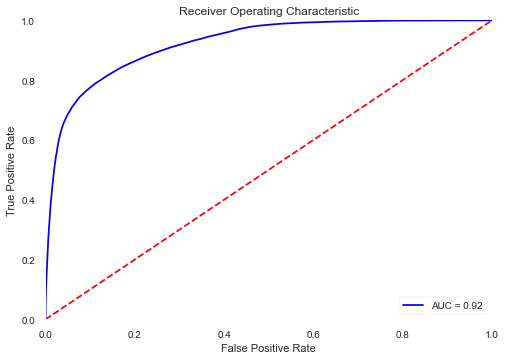

In [54]:
fpr, tpr, threshold = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
print("Score: "+ str(round(roc_auc,3)))
plt.show()

In [55]:
test = pd.read_csv("data/test.csv").set_index('ID')
date_cols = ['DATE_ARRIVAL_UTC', 'DATE_DEPARTURE_UTC', 'DATE_DEPARTURE_LCL', 'DATE_ARRIVAL_LCL']
test[date_cols] = test[date_cols].apply(pd.to_datetime)

y_scores_final = pipeline.predict_proba(test)[:, 1]

submission = pd.Series(y_scores_final, index=test.index, name='ARR_DEL15')
submission.to_csv("submission.csv")
#import ipdb; ipdb.set_trace()

--------------------------------------------------------------------------------
CreateTimeFeatures
--------------------------------------------------------------------------------
AddDurationColumn
--------------------------------------------------------------------------------
DistanceFixNA
--------------------------------------------------------------------------------
AddWeekDayColumns
--------------------------------------------------------------------------------
AddHourDayColumns
--------------------------------------------------------------------------------
JoinOrinAndDest
--------------------------------------------------------------------------------
OneHotEncoder cols=["ARRIVAL_WEEK_DAY", "DEPARTURE_WEEK_DAY", "HOUR_DAY", "DEPARTURE_HOUR_DAY"]
--------------------------------------------------------------------------------
OneHotEncoder DEP_DEL15
--------------------------------------------------------------------------------
TargetEncoder Dest and Origin
------------------

Test Model:
    - ROCAUC
    - Accuracy
    - Precison
    - Recall